<a href="https://colab.research.google.com/github/sriksmachi/sriksml/blob/main/genai/transformers_101_nmt_eng_hin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neural Machine Translation using Transformers.
==========================================================================================================

In this notebook we will create a transformer model using multi-headed attention for neural machine translation task.

A little bit about transformers, before we get started. RNNs were traditionally used for modelling seq2seq tasks, however they have few inherent challenges
- They fail to learn as the length of the sequence of input increases. In a typical Encoder-Decoder network architecture, the encoder is responsible for encoding the entire input sentence into latent vector space, which is then used by the decoder network to predict each token.
- The learning process in RNN is also sequential due to the auto regressive nature. The prediction of the next token in RNN models depends on the previous token.

The breakthough technique that made transformers so popular is the attention mechanism. Let us now understand how transformers solve this problem
- Transformers learn using self attention mechanism. Intuitevly, this means they learn the relative weights of every word with respect to other words in the sentence.
- For every next token that should be predicted the network learns the relative importance that should be given to the input tokens, that can be learned in parallel.

 Note: Attention technique can be used with RNNs as well. Using attention mechanism RNNs learn hidden state for each word so that it is easy to pay more attention or discard words rather than learning the hidden state for the entire sentence. However this does not solve 2 problems
1.   The entire process is still sequential, it cannot be parallelized
2.   For a large sentence the time taken for translating the sentence to encodings is large.

Transformers introduced a completely new concept, with some learnings from how CNNs learn embeddings in parallel. Transformers use encoder, decoder architecture to learn attention weights in parallel and they can be used for a variety of tasks like neural language translation, question answering, next word prediction etc.

Complete understanding of how transformers work is not explained in this notebook but you may refer to the following blogs for better understanding.
- https://jalammar.github.io/illustrated-transformer/
- https://mchromiak.github.io/articles/2017/Sep/12/Transformer-Attention-is-all-you-need/#.XIWlzBNKjOR

This notebook builds a transformer model following the explanation from the original paper (https://arxiv.org/pdf/1706.03762.pdf).


In [1]:
## Importing required libraries

import tensorflow as tf
from tensorflow import matmul, cast, float32,sqrt, math, transpose
from tensorflow import convert_to_tensor, string
from keras.backend import softmax
from numpy import random
from tensorflow.keras.layers import TextVectorization, Embedding, Layer, Dropout, Input
from tensorflow.keras import Model
from tensorflow.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pickle
import random
import re
import tqdm
import unicodedata
import tensorflow as tf
from tensorflow import convert_to_tensor, int64
from pickle import load
from numpy.random import shuffle
import pandas as pd

## Transformers Architecture.

The following images shows the transformers architecture.

![image.png](https://github.com/sriksmachi/sriksml/blob/main/genai/images/trans-arch.png?raw=1)

Image Source :  https://arxiv.org/pdf/1706.03762.pdf

We will use the bottom-up approach, i.e. build the transformer from the bottom most layer and then walk upwards.
This notebook builds each layer as a separate model so that they can be plugged into a full fledged model.

## Download and Preprocess

In [2]:
# for this notebook I'm using a hindi-english Truncated Corpus from OPUS, it can be downloaded from the link below
!gdown 1vyR40sftEJ1Jexoat17JzzB2cdcMVI0T

Downloading...
From: https://drive.google.com/uc?id=1vyR40sftEJ1Jexoat17JzzB2cdcMVI0T
To: /content/Hindi_English_Truncated_Corpus.csv
100% 41.4M/41.4M [00:00<00:00, 64.0MB/s]


In [3]:
ds = pd.read_csv('/content/Hindi_English_Truncated_Corpus.csv')
print(f'Total number of examples = {len(ds)}')
ds.head()

Total number of examples = 127607


,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,indic2012,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,ted,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,indic2012,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।


In [4]:
ds['eng_len']=ds['english_sentence'].apply(lambda x:len(str(x).split(" ")))
ds['hin_len']=ds['hindi_sentence'].apply(lambda x:len(str(x).split(" ")))
ds.head()

,source,english_sentence,hindi_sentence,eng_len,hin_len
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर...",12,14
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...,9,11
2,indic2012,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।,10,9
3,ted,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते,12,11
4,indic2012,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।,9,8


Let us take only sentences less than 15 words to reduce training time.

In [5]:
ds = ds[(ds['eng_len'] < 15)]
ds = ds[(ds['hin_len'] < 15)]
print(f'Total number of examples = {len(ds)}')

Total number of examples = 66074


In [6]:
# removing the punctuations
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
ds['english_sentence']=ds['english_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in filters))

In [7]:
# we can further reduce the number of examples by setting n_sentences to lower number, this can be useful for debugging
n_sentences = None
batch_size=32
if n_sentences is not None:
    ds = ds.head(n_sentences)
print(f'Total number of examples = {len(ds)}')

Total number of examples = 66074


In [8]:
# creating a list of all the english and hindi sentences
def normalize(eng, hin):
    """Normalize a line of text and split into two at the tab character"""
    eng = str(eng.strip().lower())
    hin = str(hin.strip())
    eng = "[start] " + eng + " [end]"
    hin = "[start] " + hin + " [end]"
    return eng, hin

text_pairs = []
for index in ds.index:
    text_pairs.append(normalize(ds['english_sentence'][index], ds['hindi_sentence'][index]))
print(len(text_pairs))

66074


In [9]:
text_pairs[0]

('[start] politicians do not have permission to do what needs to be done [end]',
 '[start] राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह करने कि अनुमति नहीं है . [end]')

## Prepare dataset

In [10]:
# Create train, val and testing datasets
val_split = 0.30

len_text_pairs = len(text_pairs)
n_val_index = int(val_split * len_text_pairs)
n_train_index = len_text_pairs - n_val_index

train_tp = text_pairs[:n_train_index]
val_tp = text_pairs[n_train_index:]
print(f"Train: {len(train_tp)}")
print(f"Validation: {len(val_tp)}")

Train: 46252
Validation: 19822


In [11]:
train_tp[:1]

[('[start] politicians do not have permission to do what needs to be done [end]',
  '[start] राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह करने कि अनुमति नहीं है . [end]')]

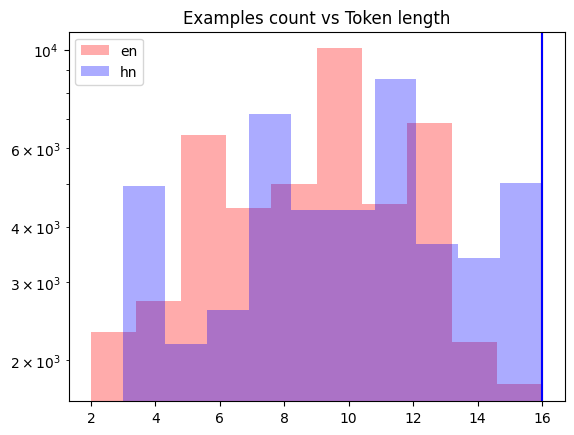

In [12]:
# histogram of sentence length in tokens
en_lengths = [len(e.split()) for e, h in train_tp]
hn_lengths = [len(h.split()) for e, h in train_tp]

plt.hist(en_lengths, label="en", color="red", alpha=0.33)
plt.hist(hn_lengths, label="hn", color="blue", alpha=0.33)
plt.yscale("log")     # sentence length fits Benford"s law
plt.ylim(plt.ylim())  # make y-axis consistent for both plots
plt.plot([max(en_lengths), max(en_lengths)], plt.ylim(), color="red")
plt.plot([max(hn_lengths), max(hn_lengths)], plt.ylim(), color="blue")
plt.legend()
plt.title("Examples count vs Token length")
plt.show()

In [13]:
 # count tokens
eng_tokens, hin_tokens = set(), set()
eng_maxlen, hin_maxlen = 0, 0
for eng, hin in text_pairs:
    eng_tok, hin_tok = eng.split(), hin.split()
    eng_maxlen = max(eng_maxlen, len(eng_tok))
    fra_maxlen = max(hin_maxlen, len(hin_tok))
    eng_tokens.update(eng_tok)
    hin_tokens.update(hin_tok)
print(f"Total English tokens: {len(eng_tokens)}")
print(f"Total Hindi tokens: {len(hin_tokens)}")
print(f"Max English length: {eng_maxlen}")
print(f"Max Hindi length: {fra_maxlen}")
print(f"{len(text_pairs)} total pairs")
vocab_size_en = len(eng_tokens)
vocab_size_hn = len(hin_tokens)

Total English tokens: 32403
Total Hindi tokens: 37674
Max English length: 16
Max Hindi length: 16
66074 total pairs


In [14]:
seq_length = 15

# Create vectorizer for english sentences
eng_vectorizer = TextVectorization(
    max_tokens=vocab_size_en,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_length,
)

# Create vectorizer for hindi sentences
# For hindi we need to use a language specific tokenizer, since the default one in tensorflow doesn't support hindi
# one such tokenizer is indic-nlp-library, which can be installed using the command below
# !pip install indic-nlp-library
hin_vectorizer = TextVectorization(
    max_tokens=vocab_size_hn,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_length + 1
)

In [15]:
# adapt the vectorizers to the training data
train_eng_texts = [pairs[0] for pairs in train_tp]
train_hin_texts = [pairs[1] for pairs in train_tp]
eng_vectorizer.adapt(train_eng_texts)
hin_vectorizer.adapt(train_hin_texts)

# set up Dataset object
def format_dataset(eng, hin):
    eng = eng_vectorizer(eng)
    hin = hin_vectorizer(hin)
    # split input and target
    # Notice that hindi is shifted by 1 to the right, as you will see later that the input to the decoder is the target sequence, right shifted by 1
    source = (eng, hin[:, :-1])
    # Notice that the target is shifted by `shift` tokens
    target = hin[:, 1:]
    return (source, target)

def make_dataset(pairs, batch_size=64):
    """Create TensorFlow Dataset for the sentence pairs"""
    # aggregate sentences using zip(*pairs)
    eng_texts, hin_texts = zip(*pairs)
    # convert them into list, and then create tensors
    dataset = tf.data.Dataset.from_tensor_slices((list(eng_texts), list(hin_texts)))
    return dataset.shuffle(2048) \
                  .batch(batch_size).map(format_dataset) \
                  .prefetch(16).cache()

train_ds = make_dataset(train_tp)
val_ds = make_dataset(val_tp)

In [16]:
# test the dataset
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs[0].shape}')
    print(f'inputs["encoder_inputs"][0]: {inputs[0][0]}')
    print(f'inputs["decoder_inputs"].shape: {inputs[1].shape}')
    print(f'inputs["decoder_inputs"][0]: {inputs[1][0]}')
    print(f"targets.shape: {targets.shape}")
    print(f"targets[0]: {targets[0]}")

inputs["encoder_inputs"].shape: (64, 15)
inputs["encoder_inputs"][0]: [   2   12   10  131   77 2220 1466   53 1711   32 2421  405    3    0
    0]
inputs["decoder_inputs"].shape: (64, 15)
inputs["decoder_inputs"][0]: [   2   21  116   38 4547 4490 4280    9 4295  208   30    3    0    0
    0]
targets.shape: (64, 15)
targets[0]: [  21  116   38 4547 4490 4280    9 4295  208   30    3    0    0    0
    0]


In [17]:
eng_lookup = list(eng_vectorizer.get_vocabulary())
hin_lookup = list(hin_vectorizer.get_vocabulary())
eng_sen, hin_tar, hin_source = "", "",""
print(inputs[1].shape)
for index in inputs[0][0]:
  eng_sen += eng_lookup[index.numpy()] + " "
for index in inputs[1][0]:
  hin_source += hin_lookup[index.numpy()] + " "
for index in targets[0]:
  hin_tar += hin_lookup[index.numpy()] + " "
print(f"source: {eng_sen}")
print(f"hin source: {hin_source}")
print(f"target: {hin_tar}")

(64, 15)
source: [start] this is why some ladies cover their faces from unknown men [end]   
hin source: [start] इस लिये कुछ स्त्रियाँ अजनबी पुर्षों से पर्दा करती हैं। [end]    
target: इस लिये कुछ स्त्रियाँ अजनबी पुर्षों से पर्दा करती हैं। [end]     


## Vocab size

In [18]:
# find out how many distinct tokens exist
print(f"Total English tokens = {vocab_size_en}.")
print(f"Total Hindi tokens = {vocab_size_hn}.")

Total English tokens = 32403.
Total Hindi tokens = 37674.


In [19]:
for (eng, hin), hn_labels in train_ds.take(1):
  break
print(eng.shape)
print(hin.shape)
print(hn_labels.shape)

print(hin[0][:10])
print(hn_labels[0][:10])

(64, 15)
(64, 15)
(64, 15)
tf.Tensor([   2   84 1330  420  528 1943  694    3    0    0], shape=(10,), dtype=int64)
tf.Tensor([  84 1330  420  528 1943  694    3    0    0    0], shape=(10,), dtype=int64)


## Positional Embedding Layer

Transformers should have the context have relative position of words in a sentence. Hence in positional encoding layer, we create encoding matrix that represent the position of the word in the sentence. Position encodings are then added to the input embeddings.

Position encodings are calculated using the below equation

![image](https://github.com/sriksmachi/sriksml/blob/main/genai/images/trans-pos-enc.png?raw=1)

- d_model -> Size of the embedding <br/>
- Pos -> position of the work in the sentence <br/>
- i -> i is used to make alternative sequences for even and odd sequences. If this is not considered then ith word on every sentence will have same position encoding

Positional encoding is a means of translating the location of objects in a sequence into information that a neural network (or other model) can understand and use.

For better understanding of how positional encoding works
- Read: https://towardsdatascience.com/master-positional-encoding-part-i-63c05d90a0c3
- Video link: https://www.youtube.com/watch?v=dichIcUZfOw

The below two cells form the input to the first encoding layer, as described in the below image.

![image.png](https://github.com/sriksmachi/sriksml/blob/main/genai/images/trans-PositionalEmbedding.png?raw=1)

Intuitively the position encoding matrix represents an overlapping sine and cosine waves, with variations for each sentence such that when all the ith positions have similar representations.

In [20]:
# Positional embedding matrix - This matrix represents the position of the word in the sentence.
# It takes input as length of the sentence and size of the vector embeddings
# The output is a matrix where every row is a word in the sentence, each row represents the position encoding of that word
# The length of each row is equal to the length of word embeddings.
def positional_encoding(length, depth):
  depth = depth/2
  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)
  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)
  return tf.cast(pos_encoding, dtype=tf.float32)

pos_matrix = positional_encoding(4, 4)
assert pos_matrix.shape == (4,4)
print(pos_matrix.shape)
print(pos_matrix)


(4, 4)
tf.Tensor(
[[ 0.          0.          1.          1.        ]
 [ 0.84147096  0.00999983  0.5403023   0.99995   ]
 [ 0.9092974   0.01999867 -0.41614684  0.9998    ]
 [ 0.14112     0.0299955  -0.9899925   0.99955004]], shape=(4, 4), dtype=float32)


In [21]:
# Positional Embedding
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    # Create a matrix of shape (vocab_size, d_model)
    # Embedding matrix maps word index to a vector of size d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=vocab_size, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [22]:
eng_pos = PositionalEmbedding(vocab_size_en, 512)
hin_pos = PositionalEmbedding(vocab_size_hn, 512)
print(eng_pos(eng).shape)
print(hin_pos(hin).shape)

(64, 15, 512)
(64, 15, 512)


## Self Attention Layer

Before understanding the input to the attention layer, let us understand how attention mechanism works.

#### Attention Mechanism
Attention mechanism contains 3 matrices : query, key and value. If you consider key, value as a dictionary, query matches one of those keys and relates to values correspondingly.
The objective here is to find the right values for these attention matrices, so that the attention scores are ideal. Because end of the day, attention scores determine what tokens to focus on.
So, how are the attention scores calculated.

- Let us take a simple sentence -> "I can see". If I consider a 4 dim embedding vector the dimension of the input will be (3 * 4). Each row represents a word in the sentence.
- We initialize the weight matrices query, key and value with a 4 * 3 matrix. Every word gets multiplied with its weight matrices resulting in its own query, key and value matrix. So, we have 3 paris of query, key and value matrices, each of size 3 * 3.  Since we are going to multiply Query and Key matrices they should be of same shape, the Value can have a different shape. You will notice that the final outcome dimension is same as dimension of value matrix.
- The input (each word has position embedding of size 1 * 4) with dim 3 * 4 gets multiplied by the weight matrix 4 * 3. This results in 3 * 3 Query matrix.
- The same operation is applied to keys, values as well.  That is, input gets multiplied by Keys, Value matrices each resulting in  3 * 3 Matrices.
- The values within attention filters are scaled by square root of the Key dimension in our case 4.
- Softmax function is applied on scores to standardize the values between 0-1
- The final matrix of size 3 * 3, is multiplied with Value filter resulting in a final out of size 3 * 3.

The steps explained above are visually represented in this rought hand sketch.

![image.png](https://github.com/sriksmachi/sriksml/blob/main/genai/images/trans-self.png?raw=1)

In the nutshell we have implemented the below mathematical operation

![image.png](https://github.com/sriksmachi/sriksml/blob/main/genai/images/trans-atten-math.png?raw=1)

#### Multi headed attention

The final attention scores are a result of one attention head. In multi-headed attention, there are multiple attention heads resulting in multiple attention matrices.
Each attention matrix learns different representations of the sentences.


In [23]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [24]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)
enc_output = eng_pos(eng)
print(enc_output.shape)
print(sample_gsa(enc_output).shape)

(64, 15, 512)
(64, 15, 512)


## Cross Attention Layer

The decoder network uses a cross attention layer. In cross attention layer, along with the input we pass the context vector to the key and value parameters.
The context vector is the final output from the encoder network, that represents the final attention scores of the input sentences across all heads. The following image represents the Cross attention part of the decoder network.

![image.png](https://github.com/sriksmachi/sriksml/blob/main/genai/images/trans-crossatten.png?raw=1)

In [25]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [26]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)
emb_output_eng = eng_pos(eng)
emb_output_hin = hin_pos(hin)
print(emb_output_eng.shape)
print(emb_output_hin.shape)
print(sample_ca(emb_output_eng, emb_output_hin).shape)

(64, 15, 512)
(64, 15, 512)
(64, 15, 512)


## Causal Self Attention

The first layer of the decoder network has different inputs compared to the other cross attention layers mentioned above.
During training phase the input to the decoder network is same as that of the encoder network, except that certain areas of the input are masked.
The causal mask ensures that for predicting a token the network has access only to the tokens that come before it.

The below images shows the part of the architecture related to causal self attention.

![image.png](https://github.com/sriksmachi/sriksml/blob/main/genai/images/trans-dec-input.png?raw=1)


In [27]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [28]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)
emb_output_eng = eng_pos(eng)
print(emb_output_eng.shape)
print(sample_csa(emb_output_eng).shape)

(64, 15, 512)
(64, 15, 512)


## Feedforward Layer

Feedforward layer is a common layer that is added on top of every Multi head attention block in both encoder and decoder networks.
The feedforward layer has 2 key components - 1. Feed forward 2. Add & Norm
The feedfoward layer is composed using a sequential model consists of 2 dense layers that perform point-wise feed forward and a drop out layer.
The outcome of the feedforward layer is added to the input (skip connection) followed by normalization layer.


In [29]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x


In [30]:
sample_ffn = FeedForward(512, 2048)
print(sample_ffn(emb_output_eng).shape)

(64, 15, 512)


## Encoder

The encoder layer is built by stacking one global attention block followed by feedforward layer, this forms one multi-headed attention block. This notebook uses 8 headed attention as configured in the paper.
You will later see that layer we stack the encoder layers, there can be any number of encoder layers. The below picture represents one encoder layer.

![image.png](https://github.com/sriksmachi/sriksml/blob/main/genai/images/trans-enc-layer.png?raw=1)

In [31]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()
    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [32]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)
print(emb_output_eng.shape)
print(sample_encoder_layer(emb_output_eng).shape)

(64, 15, 512)
(64, 15, 512)


In [33]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)
    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
    # Add dropout.
    x = self.dropout(x)
    for i in range(self.num_layers):
      x = self.enc_layers[i](x)
    return x  # Shape `(batch_size, seq_len, d_model)`.

In [34]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=vocab_size_en)
sample_encoder_output = sample_encoder(eng, training=False)
print(eng.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 15)
(64, 15, 512)


## Decoder

The decoder layer is same as encoder except that each layer contains two attention layers - causal self attention (masked inputs) and cross attention (context vector from encoder and inputs from causal attention layer).
It outcome of the causal attention layer passes through the feedforward layer as in the encoder network.

In [35]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()
    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)
    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores
    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

The decoder network can also be stacked using any number of decoder layers.

In [36]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)
    x = self.dropout(x)
    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)
    self.last_attn_scores = self.dec_layers[-1].last_attn_scores
    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [37]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=vocab_size_hn)
output = sample_decoder(x=hin,context=emb_output_eng)
# Print the shapes.
print(hin.shape)
print(emb_output_hin.shape)
print(output.shape)

(64, 15)
(64, 15, 512)
(64, 15, 512)


In [38]:
sample_decoder.last_attn_scores.shape

TensorShape([64, 8, 15, 15])

## Transformer Model

The final transformer model contains of three key components
1. Encoder Network with multiple layers of Encoders
2. Decoder Network with multiple layers of Decoders
3. The output of the decoder passes through a Dense layer that reduces the output to a dense vector of target vocab size. This is specific to the downstream task, neural machine translation in this case.

In [39]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs
    context = self.encoder(context)  # (batch_size, context_len, d_model)
    x = self.decoder(x, context)  # (batch_size, target_len, d_model)
    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)
    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

## Training Utilities

Here we are using a custom training schedule which is also used in the paper.

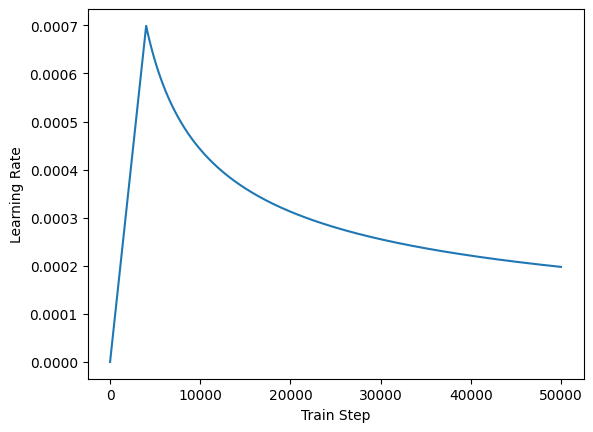

In [40]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, key_dim, warmup_steps=4000):
    super().__init__()
    self.key_dim=key_dim
    self.warmup_steps=warmup_steps
    self.d=tf.cast(self.key_dim, tf.float32)

  def __call__(self, step):
    step = tf.cast(step, tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.d) * tf.math.minimum(arg1, arg2)

  def get_config(self):
    config = {
        "key_dim": self.key_dim,
        "warmup_steps": self.warmup_steps
    }
    return config

key_dim = 512
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
plt.plot(lr(tf.range(50000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

In [41]:
# Compute masked loss
# Since we are masking the inputs that are after the current token
# the loss and accuracy should be updated to consider only the unmasked values.
def masked_loss(label, pred):
  # pred shape is (batch_size, seq_len, vocab_size)
  mask = label != 0
  # shape of mask is (batch_size, seq_len)
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
  loss = loss_object(label, pred)
  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, dtype=pred.dtype)
  match = pred==label
  mask = label !=0
  match = match & mask
  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match) / tf.reduce_sum(mask)


## Final Model

In [42]:
# Parameters
n_sentences = None
num_layers = 4
d_model = 512
dff = 512
# run with 8 heads
num_heads = 8
dropout_rate = 0.2

In [43]:
model = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=vocab_size_en,
    target_vocab_size=vocab_size_hn,
    dropout_rate=dropout_rate)
lr = CustomSchedule(dff)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])


## Training

Epoch 1/15
723/723 [==============================] - 157s 178ms/step - loss: 7.7071 - masked_accuracy: 0.1326 - val_loss: 6.3243 - val_masked_accuracy: 0.1883
Epoch 2/15
723/723 [==============================] - 116s 161ms/step - loss: 5.8406 - masked_accuracy: 0.2208 - val_loss: 5.6201 - val_masked_accuracy: 0.2483
Epoch 3/15
723/723 [==============================] - 117s 161ms/step - loss: 5.1839 - masked_accuracy: 0.2659 - val_loss: 5.2808 - val_masked_accuracy: 0.2771
Epoch 4/15
723/723 [==============================] - 117s 161ms/step - loss: 4.7151 - masked_accuracy: 0.2970 - val_loss: 5.0321 - val_masked_accuracy: 0.2975
Epoch 5/15
723/723 [==============================] - 116s 161ms/step - loss: 4.2952 - masked_accuracy: 0.3252 - val_loss: 4.9344 - val_masked_accuracy: 0.3047
Epoch 6/15
723/723 [==============================] - 117s 161ms/step - loss: 3.9244 - masked_accuracy: 0.3539 - val_loss: 4.7861 - val_masked_accuracy: 0.3212
Epoch 7/15
723/723 [====================

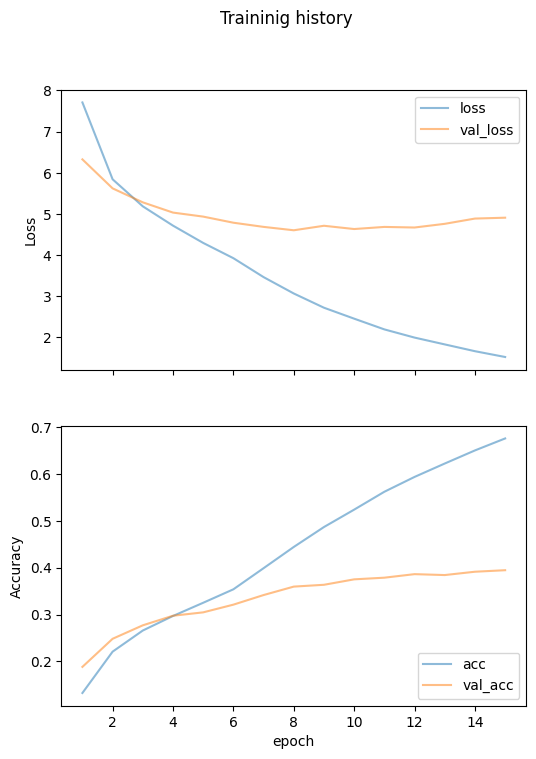

In [44]:
epochs = 15
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

# Plot the loss and accuracy history
fig, axs = plt.subplots(2, figsize=(6, 8), sharex=True)
fig.suptitle('Traininig history')
x = list(range(1, epochs+1))
axs[0].plot(x, history.history["loss"], alpha=0.5, label="loss")
axs[0].plot(x, history.history["val_loss"], alpha=0.5, label="val_loss")
axs[0].set_ylabel("Loss")
axs[0].legend(loc="upper right")
axs[1].plot(x, history.history["masked_accuracy"], alpha=0.5, label="acc")
axs[1].plot(x, history.history["val_masked_accuracy"], alpha=0.5, label="val_acc")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("epoch")
axs[1].legend(loc="lower right")
plt.show()

In [45]:
# training parameters used
seq_len = 20
def translate(sentence):
    """Create the translated sentence"""
    enc_tokens = eng_vectorizer([sentence])
    lookup = list(hin_vectorizer.get_vocabulary())
    start_sentinel, end_sentinel = "[start]", "[end]"
    output_sentence = [start_sentinel]
    # generate the translated sentence word by word
    for i in range(seq_len):
        vector = hin_vectorizer([" ".join(output_sentence)])
        dec_tokens = vector[:, :-1]
        pred = model([enc_tokens, dec_tokens])
        word = lookup[np.argmax(pred[0, i, :])]
        output_sentence.append(word)
        if word == end_sentinel:
            break
    return output_sentence

test_count = 5
for n in range(test_count):
    english_sentence, Hindi_sentence = random.choice(val_tp)
    translated = translate(english_sentence)
    print(f"Test {n}:")
    print(f"{english_sentence}")
    print(f"== {Hindi_sentence}")
    print(f"-> {' '.join(translated)}")
    print()

Test 0:
[start] but before we start we set this golden rule [end]
== [start] लेकिन शुरू करने से पहले हम ये नियम बनाते है | [end]
-> [start] लेकिन इससे पहले हमने इसे विदेशी शासक में शुरु किया । [end]

Test 1:
[start] hindi editor and spell checker [end]
== [start] हिन्दी संपादक तथा वर्तनी जाँचकर्ता [end]
-> [start] हिन्दी संपादक तथा वर्तनी जाँचकर्ता [end]

Test 2:
[start] every single day [end]
== [start] हर एक दिन. [end]
-> [start] हर दिन [end]

Test 3:
[start] four vedas [end]
== [start] चार वेद [end]
-> [start] चार वेद [end]

Test 4:
[start] very efficient process [end]
== [start] हमारी कार्यप्रणाली अत्यंत सुचारु है, [end]
-> [start] बहुत ही मजबूत प्रक्रिया से तुलना [end]



The model has overfit. since this notebook is only to understand how transformers architecture works I choose to ignore this. However, there are few ways the accuracy can be improved.
- First of all, the vectorization can be replace with language toolkits that understand "hindi".
- The english text can be tokenized better using lemmatization or sub word tokenization.
- Use more data, ofcourse the training time increases as you use more data but transformers have proven to learn better with more data.